<h1><center>FGC Post Mortem Query for a Single Day</center></h1>

# 0. Initialise the working environment
## 0.1 Install required packages for SWAN

In [1]:
import sys
if sys.version_info < (3,0):
    raise Warning("Not available for Python2. Compatible with Python3 only!")

!{sys.executable} -m pip install --user --upgrade tzlocal
!{sys.executable} -m pip install --user --upgrade lhcsmapi
!{sys.executable} -m pip install --user --upgrade influxdb

Requirement already up-to-date: tzlocal in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (2.0.0)
Requirement already up-to-date: lhcsmapi in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (1.1.34)
Requirement already up-to-date: influxdb in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (5.2.3)


## 0.2 Import useful packages

In [1]:
# External packages
import pandas as pd
import numpy as np
from datetime import timedelta, date

# Internal packages
from lhcsmapi.Time import Time
from lhcsmapi.dbsignal.Signal import Signal
from lhcsmapi.dbsignal.SignalProcessing import SignalProcessing
from lhcsmapi.metadata.SignalMetadata import SignalMetadata
from lhcsmapi.post_mortem.PmDbRequest import PmDbRequest

# 1. Choose a day, period, and component to analyse

In [9]:
selected_day_timestamp = '2015-03-13 00:00:00.000+01:00'
# selected_day_timestamp = '2018-12-12 00:00:00.000'

circuit_type = 'RB'
circuit_names = SignalMetadata.get_circuit_names_or_types(circuit_type)

# 2. Get FGC PM dumps for a single day - comparison with the Java PM Browser
<img src = "figures/JavaPMBrowserFGC.png" width=75%>

- Prepare query duration

In [7]:
event_duration_seconds = 24*60*60 # 1 day in seconds (max duration allowed in request)

print("Querying events on {}".format(selected_day_timestamp))

Querying events on 2015-03-13 00:00:00.000+01:00


- Query events for the given day
- For each event time stamp query is executed 8 times for each LHC sector

In [10]:
source_timestamp_fgc = []
for circuit_name in circuit_names:
    metadata_fgc = SignalMetadata.get_circuit_signal_database_metadata(circuit_type, circuit_name, 'PC', 'PM')
    source_timestamp_fgc += PmDbRequest.find_events(metadata_fgc['source'], metadata_fgc['system'], metadata_fgc['className'], 
                                                      t_start=selected_day_timestamp, 
                                                      duration = [(event_duration_seconds, 's')])

## 2.1 Display number of events for a single day

In [12]:
print("Total events on {}: {}".format(selected_day_timestamp, len(source_timestamp_fgc)))

Total events on 2015-03-13 00:00:00.000+01:00: 10


## 2.2 Display event source and timestamp of a single day

In [14]:
for source, timestamp in source_timestamp_fgc:
    print('Analysing quench heater firing of {} on {}, {}'\
          .format(source, Time.to_string(timestamp), timestamp))

Analysing quench heater firing of RPTE.UA27.RB.A23 on 2015-03-13 19:25:25.440000+01:00, 1426271125440000000
Analysing quench heater firing of RPTE.UA43.RB.A34 on 2015-03-13 07:50:08.120000+01:00, 1426229408120000000
Analysing quench heater firing of RPTE.UA43.RB.A34 on 2015-03-13 09:53:22.380000+01:00, 1426236802380000000
Analysing quench heater firing of RPTE.UA43.RB.A34 on 2015-03-13 18:32:12+01:00, 1426267932000000000
Analysing quench heater firing of RPTE.UA47.RB.A45 on 2015-03-13 05:21:09.520000+01:00, 1426220469520000000
Analysing quench heater firing of RPTE.UA47.RB.A45 on 2015-03-13 13:54:45.740000+01:00, 1426251285740000000
Analysing quench heater firing of RPTE.UA47.RB.A45 on 2015-03-13 21:13:46.400000+01:00, 1426277626400000000
Analysing quench heater firing of RPTE.UA63.RB.A56 on 2015-03-13 18:49:39.560000+01:00, 1426268979560000000
Analysing quench heater firing of RPTE.UA83.RB.A78 on 2015-03-13 15:58:36.320000+01:00, 1426258716320000000
Analysing quench heater firing of R

## 2.3 Choose an event to be analysed

In [15]:
index_event = 0
source, timestamp = source_timestamp_fgc[index_event]

## 2.4 Process a single FGC event of a single day - get raw data
- get current

<IPython.core.display.Javascript object>


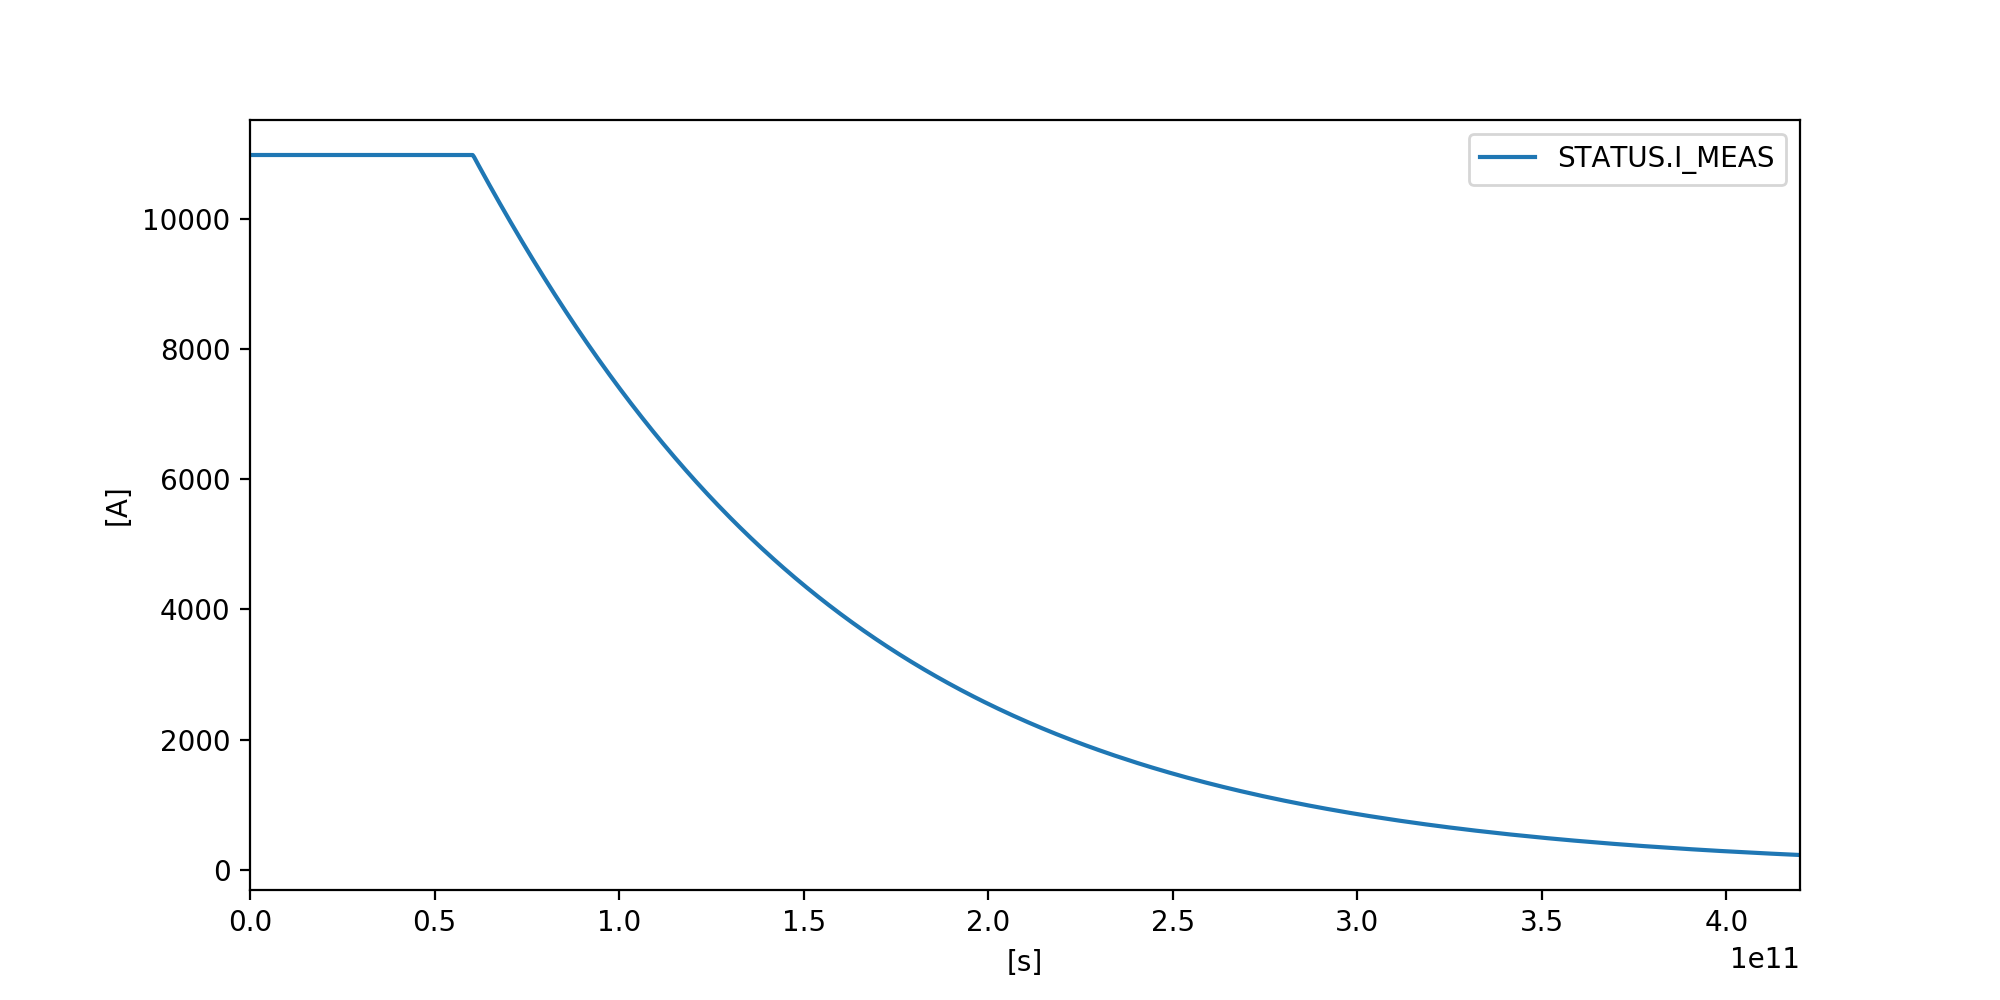

[Text(0, 0.5, '[A]'), Text(0.5, 0, '[s]')]

In [24]:
circuit_name = SignalMetadata.get_sector_names_from_components(circuit_type, 'PC', source)
I_MEAS = SignalMetadata.get_signal_name(circuit_type, circuit_name, 'PC', 'PM', 'I_MEAS')

fgc_signal = Signal()
fgc_signal.read('pm',append=True, system=metadata_fgc['system'], className=metadata_fgc['className'],
                            source=source, signal=I_MEAS, eventTime=timestamp)
fgc_df = fgc_signal.get_synchronized_time_df()
%matplotlib notebook
fgc_df.filter(regex=(I_MEAS)).plot(figsize=(10,5)).set(xlabel="[s]", ylabel="[A]")

- Plot current

### 2.4.1 Compare raw data from REST API to Java PM Browser\n
<img src = "figures/JavaPMBrowserFGCCurrent.png" width=50%>

## 2.5 Process single event of a single day - filter signals
- filter all signals

In [25]:
filter_names = []
SignalProcessing.filter_signal_names(fgc_df, filter_names)

STATUS.I_MEAS
0               10980.00100
20000000        10979.99700
40000000        10980.00100
60000000        10979.99900
80000000        10980.00000
100000000       10980.00000
120000000       10980.00000
140000000       10979.99900
160000000       10980.00200
180000000       10979.99900
200000000       10980.00300
220000000       10980.00400
240000000       10980.00600
260000000       10980.00500
280000000       10980.00100
300000000       10980.00100
320000000       10980.00000
340000000       10980.00000
360000000       10979.99800
380000000       10980.00200
400000000       10980.00200
420000000       10980.00100
440000000       10980.00200
460000000       10980.00000
480000000       10979.99800
500000000       10979.99800
520000000       10979.99800
540000000       10979.99900
560000000       10980.00200
580000000       10980.00100
...                     ...
419400000000      228.32904
419420000000      228.27702
419440000000      228.22565
419460000000      228.17525
419480000000      228.12585
419500000000      228.07448
419520000000      228.02475
419540000000      227.97534
419560000000      227.92332
419580000000      227.86964
419600000000      227.81958
419620000000      227.76591
419640000000      227.71650
419660000000      227.66579
419680000000      227.61375
419700000000      227.56238
419720000000      227.51134
419740000000      227.45996
419760000000      227.41087
419780000000      227.36017
419800000000      227.30748
419820000000      227.25839
419840000000      227.20834
419860000000      227.15794
419880000000      227.10658
419900000000      227.05650
419920000000      227.00284
419940000000      226.95049
419960000000      226.90207
419980000000      226.84972

[21000 rows x 1 columns]

## 2.6 Process single event of a single day - calculate features as a table,
- calculate features: min value, max value, mean value, std value, start value, end value

In [26]:
function_names_to_apply = ["max", "min", "mean", "std", "first", "last"]
fgc_features_df = SignalProcessing.get_feature_dataframe(fgc_df, function_names_to_apply)
fgc_features_df

STATUS.I_MEAS
max     10980.006000
min       226.849720
mean     4031.577414
std      3891.383197
first   10980.001000
last      226.849720

## 2.7 Process single event of a single day - calculate features as a row
- calculate features: min value, max value, mean value, std value, start value, end value

In [27]:
row_fgc_features_df = SignalProcessing.convert_feature_dataframe_into_row(fgc_features_df, timestamp)
row_fgc_features_df

STATUS.I_MEAS_max  STATUS.I_MEAS_min  STATUS.I_MEAS_mean  \
timestamp                                                                       
1426271125440000000          10980.006          226.84972         4031.577414   

                     STATUS.I_MEAS_std  STATUS.I_MEAS_first  \
timestamp                                                     
1426271125440000000        3891.383197            10980.001   

                     STATUS.I_MEAS_last  
timestamp                                
1426271125440000000           226.84972

# 3. Write final dataframe a row to a csv file

In [28]:
file_name = '{}_{}_Timestamp_features.csv'.format(circuit_type, selected_day_timestamp)

print("Writing dataframe as a row to a csv file: {}".format(file_name))

# uncomment to write to a file
# rowFeatureDfPm.to_csv(fileName)

Writing dataframe as a row to a csv file: RB_2015-03-13 00:00:00.000+01:00_Timestamp_features.csv
